# Worch vs Torch: Tests

**TODO**:

1. reset `module.previous_input`. Either automatically if we detect shape inconsistencies, or manually through a method, or both. Maybe detection + call method in optimizer.zero_grad() ? (because the batch size is static currently)

In [92]:
import torch
import worch
from worch import nn
from worch import optim
from test_utils import generate_data
import matplotlib.pyplot as plt
torch.set_grad_enabled(False)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Linear Forward (YES)

In [93]:
x = torch.empty((2, 2)).normal_()
y = torch.empty((2, 2)).normal_()

In [94]:
wfc = worch.nn.Linear(x.shape[1], 10)
tfc = torch.nn.Linear(x.shape[1], 10)
p = tfc.state_dict()
wfc.params[0].shape == p['weight'].shape

True

In [95]:
wfc.params[0] = p['weight']
wfc.params[1] = p['bias']

In [96]:
(wfc(x)).allclose(tfc(x))

True

In [97]:
torch.max(torch.abs(wfc(x)-tfc(x)))

tensor(0.)

# Linear Backward (YES)

In [98]:
x = torch.Tensor([[1, 2, 3],
                  [3, 4, 2]])
y_ = torch.ones((x.shape[0], 1))

In [99]:
wfc = worch.nn.Linear(x.shape[1], 1)
tfc = torch.nn.Linear(x.shape[1], 1)
p = tfc.state_dict()
wfc.params[0] = p['weight']
wfc.params[1] = p['bias']
wc = worch.nn.MSELoss()
wc.register_previous_module(wfc)
tc = torch.nn.MSELoss()

In [100]:
# Worch
y_worch = wfc(x)
loss_worch = wc(y_worch, y_)
wc.backward()
wfc.params[0].grad, wfc.params[1].grad, loss_worch

(tensor([[-1.8258, -2.5734, -1.7039]]), tensor([-0.7476]), tensor(0.6682))

In [101]:
# Torch
torch.set_grad_enabled(True)
x_torch = x.clone()
x_torch.requires_grad_(True)
y_torch = tfc(x_torch)
loss_torch = tc(y_torch, y_)
torch.set_grad_enabled(False)
loss_torch.backward()
tfc.weight.grad, tfc.bias.grad, loss_torch

(tensor([[-3.6516, -5.1469, -3.4077]]),
 tensor([-1.4953]),
 tensor(0.6682, grad_fn=<MseLossBackward>))

# ReLU Forward (YES)

In [102]:
x = torch.empty((2, 2)).normal_()
y = torch.empty((2, 2)).normal_()

In [103]:
(worch.nn.ReLU()(x)).allclose(torch.nn.ReLU()(x))

True

In [104]:
torch.max(torch.abs(worch.nn.ReLU()(x)-torch.nn.ReLU()(x)))

tensor(0.)

# ReLU Backward (YES)

In [105]:
x

tensor([[ 0.3108, -0.3188],
        [-1.2202,  1.0524]])

In [106]:
# Worch
wrelu = worch.nn.ReLU()
b = wrelu(x)
wrelu.backward(b)

tensor([[0.3108, 0.0000],
        [0.0000, 1.0524]])

In [107]:
# Torch
torch.set_grad_enabled(True)
trelu = torch.nn.ReLU()
x_torch = x.clone()
x_torch.requires_grad_(True)
b = trelu(x_torch)
b.backward(x_torch)
x_torch.grad

tensor([[0.3108, 0.0000],
        [0.0000, 1.0524]])

# Sigmoid Forward (YES)

In [108]:
x = torch.empty((2, 2)).normal_()
y = torch.empty((2, 2)).normal_()

In [109]:
(worch.nn.Sigmoid()(x)).allclose(torch.nn.Sigmoid()(x))

True

In [110]:
torch.max(torch.abs(worch.nn.Sigmoid()(x)-torch.nn.Sigmoid()(x)))

tensor(0.)

# Sigmoid Backward (NO)

In [111]:
x

tensor([[-0.3085,  0.7158],
        [-0.3074,  1.4279]])

In [112]:
# Worch
wsig = worch.nn.Sigmoid()
b = wsig(x)
wsig.backward(b)

tensor([[0.1034, 0.1481],
        [0.1035, 0.1258]])

In [113]:
# Torch
torch.set_grad_enabled(True)
tsig = torch.nn.Sigmoid()
x_torch = x.clone()
x_torch.requires_grad_(True)
b = tsig(x_torch)
b.backward(x_torch)
x_torch.grad

tensor([[-0.0753,  0.1579],
        [-0.0751,  0.2228]])

# Tanh Forward (YES)

In [114]:
x = torch.empty((2, 2)).normal_()
y = torch.empty((2, 2)).normal_()

In [115]:
(worch.nn.Tanh()(x)).allclose(torch.nn.Tanh()(x))

True

In [116]:
torch.max(torch.abs(worch.nn.Tanh()(x)-torch.nn.Tanh()(x)))

tensor(1.1921e-07)

# Tanh Backward (NO)

In [117]:
x

tensor([[ 1.4869, -1.6125],
        [ 1.0155, -0.9902]])

In [118]:
# Worch
wtgh = worch.nn.Tanh()
b = wtgh(x)
wtgh.backward(b)

tensor([[ 0.1670, -0.1358],
        [ 0.3150, -0.3229]])

In [119]:
# Torch
torch.set_grad_enabled(True)
tgh = torch.nn.Tanh()
x_torch = x.clone()
x_torch.requires_grad_(True)
b = tgh(x_torch)
b.backward(x_torch)
x_torch.grad

tensor([[ 0.2751, -0.2372],
        [ 0.4165, -0.4221]])

# MSE Forward (YES)
like pytorch for comparison `mse = mean((input-target)**2)`

In [120]:
x = torch.empty((2, 2)).normal_()
y = torch.empty((2, 2)).normal_()

In [121]:
(worch.nn.MSELoss()(x, y)).allclose(torch.nn.MSELoss()(x, y))

True

In [122]:
torch.max(worch.nn.MSELoss()(x, y)-torch.nn.MSELoss()(x, y))

tensor(0.)

# MSE Backward (YES)
like pytorch for comparison `g = (input-target)*0.5`

In [123]:
x, y

(tensor([[-0.2213,  1.2161],
         [ 0.3322, -0.7773]]),
 tensor([[ 0.4168, -0.2098],
         [ 1.5163, -0.3114]]))

In [124]:
# Worch
wc = worch.nn.MSELoss()
b = wc(x, y)
g = wc.backward()
g

tensor([[-0.3191,  0.7130],
        [-0.5921, -0.2330]])

In [125]:
# Torch
torch.set_grad_enabled(True)
tc = torch.nn.MSELoss()
x_torch = x.clone()
x_torch.requires_grad_(True)
b = tc(x_torch, y)
b.backward()
torch.set_grad_enabled(False)
x_torch.grad

tensor([[-0.3191,  0.7130],
        [-0.5921, -0.2330]])

# Sequential Forward (YES)

In [245]:
x = torch.empty((2, 2)).normal_()
y = torch.empty((2, 2)).normal_()

In [246]:
wfc1 = worch.nn.Linear(x.shape[1], 10)
tfc1 = torch.nn.Linear(x.shape[1], 10)
p = tfc1.state_dict()
wfc1.params[0] = p['weight']
wfc1.params[1]=p['bias']
wfc2 = worch.nn.Linear(10, y.shape[1])
tfc2 = torch.nn.Linear(10, y.shape[1])
p = tfc2.state_dict()
wfc2.params[0] = p['weight']
wfc2.params[1]=p['bias']

In [247]:
wnet =  worch.nn.Sequential(
    wfc1,
    worch.nn.ReLU(),
    wfc2,
)
tnet =  torch.nn.Sequential(
    tfc1,
    torch.nn.ReLU(),
    tfc2,
)

In [248]:
(wnet(x)).allclose(tnet(x))

True

In [249]:
torch.max(torch.abs(wnet(x)-tnet(x)))

tensor(0.)

# Sequential Backward (YES)
Cells must be run the exact same number of times because of accumulation.

In [250]:
x, y

(tensor([[-0.4512,  1.8746],
         [ 1.7148,  0.5032]]),
 tensor([[-2.5398, -1.0340],
         [ 1.3754,  0.7292]]))

In [251]:
# Worch
wc = worch.nn.MSELoss()
wc.register_previous_module(wnet)
y_worch = wnet(x)
loss_worch = wc(y_worch, y)
wgl = wc.backward()
wgw0 = wnet[0].params[0].grad
wgb0 = wnet[0].params[1].grad
wgw1 = wnet[2].params[0].grad
wgb1 = wnet[2].params[1].grad

In [252]:
# Torch
tc = torch.nn.MSELoss()
torch.set_grad_enabled(True)
x_torch = x.clone()
x_torch.requires_grad_(True)
y_torch = tnet(x_torch)
loss_torch = tc(y_torch, y)
torch.set_grad_enabled(False)
tgl = loss_torch.backward()
tgw0 = tnet[0].weight.grad
tgb0 = tnet[0].bias.grad
tgw1 = tnet[2].weight.grad
tgb1 = tnet[2].bias.grad

In [253]:
tgb1.allclose(wgb1)

True

In [254]:
tgw1.allclose(wgw1)

True

In [255]:
tgb0.allclose(wgb0)

True

In [256]:
tgw0.allclose(wgw0)

True

# SGD (YES)
Cells must be run the exact same number of times because of sgd updates.

In [257]:
# Reusing network above
wsgd = worch.optim.SGD(wnet.parameters(), lr=0.01)
tsgd = torch.optim.SGD(tnet.parameters(), lr=0.01)

In [258]:
# Worch
wc = worch.nn.MSELoss()
wc.register_previous_module(wnet)
y_worch = wnet(x)
loss_worch = wc(y_worch, y)
wsgd.zero_grad()
wc.backward()
wsgd.step()
ww0 = wnet[0].params[0]
wb0 = wnet[0].params[1]
ww1 = wnet[2].params[0]
wb1 = wnet[2].params[1]

In [259]:
# Torch
tc = torch.nn.MSELoss()
torch.set_grad_enabled(True)
x_torch = x.clone()
x_torch.requires_grad_(True)
y_torch = tnet(x_torch)
loss_torch = tc(y_torch, y)
tsgd.zero_grad()
loss_torch.backward()
tsgd.step()
torch.set_grad_enabled(False)
tw0 = tnet[0].weight
tb0 = tnet[0].bias
tw1 = tnet[2].weight
tb1 = tnet[2].bias

In [261]:
tb1.allclose(wb1)

True

In [262]:
tw1.allclose(ww1)

True

In [263]:
tw0.allclose(ww0)

True

In [264]:
tb0.allclose(wb0)

True

# Training

In [282]:
kind = 'disk'
X, Y = generate_data(n=1000, kind=kind)

In [283]:
X.shape, Y.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

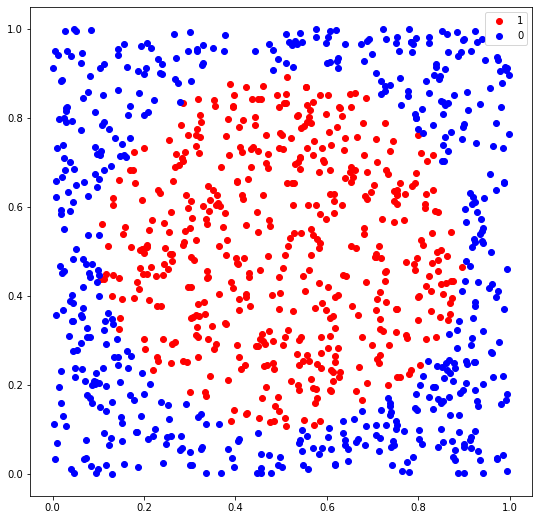

In [284]:
# Plot data
if kind == 'disk':
    X1 = X[Y.squeeze(-1).bool()].numpy()
    X0 = X[~Y.squeeze(-1).bool()].numpy()
    plt.scatter(X1[:,0], X1[:,1], color='r', label='1')
    plt.scatter(X0[:,0], X0[:,1], color='b', label='0')
    plt.legend()
    plt.rcParams['figure.figsize'] = (9,9)
    plt.show()
else:
    plt.plot(X[:100], Y[:100])
    plt.rcParams['figure.figsize'] = (9,9)
    plt.show()

In [285]:
# Standardization
X_test, Y_test = generate_data(n=1000, kind=kind)
mu, std = X.mean(0), X.std(0)
X = X.sub_(mu).div_(std)
X_test = X_test.sub_(mu).div_(std)

In [278]:
device = 'cpu'
model =  worch.nn.Sequential(
    worch.nn.Linear(X.shape[1], 4),
    worch.nn.ReLU(),
    worch.nn.Linear(4, 4),
    worch.nn.ReLU(),
    worch.nn.Linear(4, 1)    
)
model.to(device)
optimizer = worch.optim.SGD(
    model.parameters(), lr=0.1)
criterion = worch.nn.MSELoss()
# Required boilerplate because the tensor do not carry the gradfn attributes along, all in the modules
criterion.register_previous_module(model.module_list[-1])

In [279]:
num_epochs = 8
batch_size = 5
train_losses = []
test_losses = []
train_tlosses = []
test_tlosses = []
print('W')
print(model.module_list[-1].params[0])
for epoch in range(num_epochs):
    # Training
    model.train()
    losses = []
    for b in range(0, X.size(0), batch_size):
        print('grad')
        print(model.module_list[-1].params[0].grad)
        x, y = X[b:b+batch_size], Y[b:b+batch_size].long()
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        print('grad after zero grad')
        print(model.module_list[-1].params[0].grad)
        criterion.backward() # call on module not tensor
        print('grad backward')
        print(model.module_list[-1].params[0].grad)
        optimizer.step()
        losses.append(loss.cpu().detach().item())
        print('y,yp')
        print(y, y_pred)
        print('loss')
        print(loss)
        print('W')
        print(model.module_list[-1].params[0])
#         break
    mean_loss = torch.mean(torch.Tensor(losses))
    train_losses.append(mean_loss)
    # Evaluation
    model.eval()
    losses = []
    tlosses = []
    for b in range(0, X_test.size(0), batch_size):
        x, y = X_test[b:b+batch_size], Y_test[b:b+batch_size].long()
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        losses.append(loss.cpu().detach().item())
    mean_loss = torch.mean(torch.Tensor(losses))
    test_losses.append(mean_loss)
    # Feedback
    if epoch == 0 or(epoch+1) % 10  == 0:
        print(f'[(worch) {epoch+1}/{num_epochs}] train loss = {train_losses[-1]}, test loss = {test_losses[-1]}')

W
tensor([[-0.8926,  0.3176, -0.3700, -0.1947]])
grad
None
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[ -0.3958,   0.0000, -41.9598,   0.0000]])
y,yp
tensor([[12],
        [14],
        [23],
        [13],
        [11]]) tensor([[-0.9612],
        [-0.7855],
        [-1.4077],
        [-0.9979],
        [-0.9306]])
loss
tensor(264.1238)
W
tensor([[-0.8530,  0.3176,  3.8259, -0.1947]])
grad
tensor([[ -0.3958,   0.0000, -41.9598,   0.0000]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[10],
        [13],
        [17],
        [14],
        [21]]) tensor([[3.2415],
        [3.2415],
        [3.2415],
        [3.2415],
        [3.2415]])
loss
tensor(152.2626)
W
tensor([[-0.8530,  0.3176,  3.8259, -0.1947]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[ 0.0000,  0.0000, -1.8186, -3.1456]])
y,yp
tensor([[13],
        [20],
        [13],
        [12],


tensor([[0., 0., 0., 0.]])
y,yp
tensor([[15],
        [14],
        [13],
        [ 8],
        [16]]) tensor([[12.6511],
        [12.6511],
        [12.6511],
        [12.6511],
        [12.6511]])
loss
tensor(8.0612)
W
tensor([[  -0.8530,   -5.1509, -261.9431,   -3.6930]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[ 9],
        [22],
        [ 9],
        [ 9],
        [17]]) tensor([[12.7884],
        [12.7884],
        [12.7884],
        [12.7884],
        [12.7884]])
loss
tensor(29.1294)
W
tensor([[  -0.8530,   -5.1509, -261.9431,   -3.6930]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[18],
        [14],
        [14],
        [12],
        [14]]) tensor([[12.8913],
        [12.8913],
        [12.8913],
        [12.8913],
        [12.8913]])
loss
tensor(6.1163)
W
tensor([[  -0.8530,   -5.1509, -261.94

tensor([[0., 0., 0., 0.]])
y,yp
tensor([[ 7],
        [ 5],
        [17],
        [ 7],
        [18]]) tensor([[14.5369],
        [14.5369],
        [14.5369],
        [14.5369],
        [14.5369]])
loss
tensor(44.5243)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[10],
        [18],
        [ 8],
        [13],
        [ 9]]) tensor([[13.6027],
        [13.6027],
        [13.6027],
        [13.6027],
        [13.6027]])
loss
tensor(17.0506)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[16],
        [15],
        [17],
        [22],
        [ 9]]) tensor([[13.1020],
        [13.1020],
        [13.1020],
        [13.1020],
        [13.1020]])
loss
tensor(24.6392)
W
tensor([[  -0.7224,   -5.1086, -261.

        [10]]) tensor([[13.4028],
        [13.4028],
        [13.4028],
        [13.4028],
        [13.4028]])
loss
tensor(11.1677)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[11],
        [17],
        [13],
        [13],
        [11]]) tensor([[13.0521],
        [13.0521],
        [13.0521],
        [13.0521],
        [13.0521]])
loss
tensor(4.8027)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[ 8],
        [ 5],
        [17],
        [13],
        [16]]) tensor([[13.0390],
        [13.0390],
        [13.0390],
        [13.0390],
        [13.0390]])
loss
tensor(22.8952)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 

tensor([[16],
        [15],
        [11],
        [ 6],
        [18]]) tensor([[14.4310],
        [14.4310],
        [14.4310],
        [14.4310],
        [14.4310]])
loss
tensor(19.6753)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[17],
        [14],
        [ 3],
        [15],
        [12]]) tensor([[14.1232],
        [14.1232],
        [14.1232],
        [14.1232],
        [14.1232]])
loss
tensor(27.4588)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[19],
        [14],
        [18],
        [21],
        [17]]) tensor([[13.6424],
        [13.6424],
        [13.6424],
        [13.6424],
        [13.6424]])
loss
tensor(22.6454)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([

tensor([[0., 0., 0., 0.]])
y,yp
tensor([[12],
        [16],
        [15],
        [ 7],
        [ 6]]) tensor([[13.1635],
        [13.1635],
        [13.1635],
        [13.1635],
        [13.1635]])
loss
tensor(20.4153)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[ 9],
        [16],
        [12],
        [16],
        [17]]) tensor([[12.6726],
        [12.6726],
        [12.6726],
        [12.6726],
        [12.6726]])
loss
tensor(10.9619)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[16],
        [17],
        [17],
        [19],
        [12]]) tensor([[13.0045],
        [13.0045],
        [13.0045],
        [13.0045],
        [13.0045]])
loss
tensor(15.5714)
W
tensor([[  -0.7224,   -5.1086, -261.

y,yp
tensor([[ 8],
        [21],
        [13],
        [ 6],
        [16]]) tensor([[14.0955],
        [14.0955],
        [14.0955],
        [14.0955],
        [14.0955]])
loss
tensor(31.0383)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[16],
        [ 8],
        [16],
        [24],
        [14]]) tensor([[13.7716],
        [13.7716],
        [13.7716],
        [13.7716],
        [13.7716]])
loss
tensor(29.5829)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[12],
        [10],
        [ 9],
        [14],
        [12]]) tensor([[14.2287],
        [14.2287],
        [14.2287],
        [14.2287],
        [14.2287]])
loss
tensor(11.0417)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
ten

tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[21],
        [ 5],
        [11],
        [ 2],
        [ 9]]) tensor([[14.4283],
        [14.4283],
        [14.4283],
        [14.4283],
        [14.4283]])
loss
tensor(65.5522)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[ 9],
        [19],
        [16],
        [ 9],
        [20]]) tensor([[13.2212],
        [13.2212],
        [13.2212],
        [13.2212],
        [13.2212]])
loss
tensor(24.5411)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[17],
        [ 9],
        [13],
        [10],
        [17]]) tensor

tensor(24.4159)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[ 6],
        [21],
        [20],
        [11],
        [15]]) tensor([[14.5203],
        [14.5203],
        [14.5203],
        [14.5203],
        [14.5203]])
loss
tensor(31.4464)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[20],
        [ 6],
        [14],
        [21],
        [22]]) tensor([[14.5402],
        [14.5402],
        [14.5402],
        [14.5402],
        [14.5402]])
loss
tensor(40.0828)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[ 6],
        [22],
        [21],
        [15],
   

grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[25],
        [15],
        [17],
        [16],
        [ 7]]) tensor([[13.4877],
        [13.4877],
        [13.4877],
        [13.4877],
        [13.4877]])
loss
tensor(39.1116)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[12],
        [ 6],
        [ 5],
        [19],
        [10]]) tensor([[14.1158],
        [14.1158],
        [14.1158],
        [14.1158],
        [14.1158]])
loss
tensor(38.8470)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[14],
        [22],
        [15],
        [11],
        [11]]) tensor([[13.1868],
        [13.1868],
        [13.1868],
        [13.1868],
        [13.1868]])
loss
tensor(18.2370)
W
tensor([[  -0.7224,   

tensor(21.9370)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[14],
        [16],
        [12],
        [16],
        [14]]) tensor([[14.3738],
        [14.3738],
        [14.3738],
        [14.3738],
        [14.3738]])
loss
tensor(2.2407)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[20],
        [19],
        [21],
        [18],
        [19]]) tensor([[14.3804],
        [14.3804],
        [14.3804],
        [14.3804],
        [14.3804]])
loss
tensor(26.2367)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[18],
        [19],
        [ 7],
        [22],
    

tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[17],
        [21],
        [16],
        [17],
        [ 7]]) tensor([[15.2038],
        [15.2038],
        [15.2038],
        [15.2038],
        [15.2038]])
loss
tensor(21.5970)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[11],
        [ 9],
        [12],
        [20],
        [20]]) tensor([[15.3029],
        [15.3029],
        [15.3029],
        [15.3029],
        [15.3029]])
loss
tensor(22.6551)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[ 8],
        [14],
        [ 9],
        [17],
        [20]]) tensor

tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[14],
        [10],
        [ 9],
        [24],
        [10]]) tensor([[14.1163],
        [14.1163],
        [14.1163],
        [14.1163],
        [14.1163]])
loss
tensor(31.5531)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[16],
        [13],
        [24],
        [11],
        [20]]) tensor([[13.9372],
        [13.9372],
        [13.9372],
        [13.9372],
        [13.9372]])
loss
tensor(30.3554)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[ 8],
        [15],
        [22],
        [13],
        [14]]) tensor([[14.6529],
        [14.6529],
        [14.6529],
        [14.6529],
        [14.6529]])
loss
tensor(20.304

tensor(2.2407)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[20],
        [19],
        [21],
        [18],
        [19]]) tensor([[14.3804],
        [14.3804],
        [14.3804],
        [14.3804],
        [14.3804]])
loss
tensor(26.2367)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[18],
        [19],
        [ 7],
        [22],
        [18]]) tensor([[15.6353],
        [15.6353],
        [15.6353],
        [15.6353],
        [15.6353]])
loss
tensor(27.5166)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[17],
        [16],
        [17],
        [11],
    

tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[ 8],
        [14],
        [ 9],
        [17],
        [20]]) tensor([[15.0771],
        [15.0771],
        [15.0771],
        [15.0771],
        [15.0771]])
loss
tensor(23.2219)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[12],
        [ 8],
        [ 9],
        [ 8],
        [15]]) tensor([[14.7079],
        [14.7079],
        [14.7079],
        [14.7079],
        [14.7079]])
loss
tensor(25.9976)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[15],
        [ 9],
        [15],
        [ 5],
        [19]]) tensor([[13.6309],
        [13.6309],
        [13.6309],
        [

tensor([[ 7],
        [15],
        [14],
        [12],
        [11]]) tensor([[14.5897],
        [14.5897],
        [14.5897],
        [14.5897],
        [14.5897]])
loss
tensor(15.5424)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[ 8],
        [12],
        [12],
        [22],
        [17]]) tensor([[13.8923],
        [13.8923],
        [13.8923],
        [13.8923],
        [13.8923]])
loss
tensor(23.4547)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[23],
        [11],
        [13],
        [18],
        [15]]) tensor([[13.9692],
        [13.9692],
        [13.9692],
        [13.9692],
        [13.9692]])
loss
tensor(21.7241)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([

tensor([[0., 0., 0., 0.]])
y,yp
tensor([[11],
        [12],
        [15],
        [24],
        [15]]) tensor([[14.8051],
        [14.8051],
        [14.8051],
        [14.8051],
        [14.8051]])
loss
tensor(21.3939)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[15],
        [22],
        [17],
        [ 9],
        [17]]) tensor([[14.9538],
        [14.9538],
        [14.9538],
        [14.9538],
        [14.9538]])
loss
tensor(18.6945)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[21],
        [12],
        [12],
        [16],
        [20]]) tensor([[15.2154],
        [15.2154],
        [15.2154],
        [15.2154],
        [15.2154]])
loss
tensor(15.5295)
W
tensor([[  -0.7224,   -5.1086, -261.

grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[ 2],
        [18],
        [14],
        [ 8],
        [16]]) tensor([[12.6805],
        [12.6805],
        [12.6805],
        [12.6805],
        [12.6805]])
loss
tensor(35.4075)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[ 5],
        [17],
        [13],
        [16],
        [15]]) tensor([[12.4104],
        [12.4104],
        [12.4104],
        [12.4104],
        [12.4104]])
loss
tensor(19.1835)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[10],
        [21],
        [11],
        [ 5],
        [16]]) tensor([[12.6078],
        [12.6078],
        [12.6078],
        [12.6078],
        [12.6078]])
loss
tensor(29.8401)
W
tensor([[  -0.7224,   

tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[20],
        [11],
        [ 3],
        [20],
        [13]]) tensor([[13.7600],
        [13.7600],
        [13.7600],
        [13.7600],
        [13.7600]])
loss
tensor(40.3696)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[ 6],
        [22],
        [17],
        [12],
        [17]]) tensor([[13.6700],
        [13.6700],
        [13.6700],
        [13.6700],
        [13.6700]])
loss
tensor(30.6369)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[17],
        [ 6],
        [17],
        [ 9],
        [17]]) tensor

tensor([[0., 0., 0., 0.]])
y,yp
tensor([[19],
        [ 3],
        [16],
        [13],
        [ 4]]) tensor([[14.7461],
        [14.7461],
        [14.7461],
        [14.7461],
        [14.7461]])
loss
tensor(55.2336)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[19],
        [11],
        [ 8],
        [20],
        [20]]) tensor([[13.8096],
        [13.8096],
        [13.8096],
        [13.8096],
        [13.8096]])
loss
tensor(29.0455)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[13],
        [13],
        [10],
        [ 8],
        [15]]) tensor([[14.2572],
        [14.2572],
        [14.2572],
        [14.2572],
        [14.2572]])
loss
tensor(12.1979)
W
tensor([[  -0.7224,   -5.1086, -261.

grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[12],
        [14],
        [23],
        [13],
        [11]]) tensor([[12.3658],
        [12.3658],
        [12.3658],
        [12.3658],
        [12.3658]])
loss
tensor(23.6317)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[10],
        [13],
        [17],
        [14],
        [21]]) tensor([[12.9243],
        [12.9243],
        [12.9243],
        [12.9243],
        [12.9243]])
loss
tensor(18.3084)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[13],
        [20],
        [13],
        [12],
        [14]]) tensor([[13.4433],
        [13.4433],
        [13.4433],
    

grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[17],
        [13],
        [16],
        [13],
        [19]]) tensor([[13.8976],
        [13.8976],
        [13.8976],
        [13.8976],
        [13.8976]])
loss
tensor(8.3381)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[15],
        [13],
        [19],
        [ 6],
        [11]]) tensor([[14.3232],
        [14.3232],
        [14.3232],
        [14.3232],
        [14.3232]])
loss
tensor(20.8802)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[13],
        [21],
        [12],
        [ 5],
        [ 6]]) tensor([[13.9424],
        [13.9424],
        [13.9424],
        [13.9424],
        [13.9424]]

grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[ 9],
        [16],
        [17],
        [ 7],
        [18]]) tensor([[14.6133],
        [14.6133],
        [14.6133],
        [14.6133],
        [14.6133]])
loss
tensor(21.7122)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[ 9],
        [14],
        [18],
        [24],
        [12]]) tensor([[14.3100],
        [14.3100],
        [14.3100],
        [14.3100],
        [14.3100]])
loss
tensor(28.2281)
W
tensor([[  -0.7224,   -5.1086, -261.9431,   -3.5970]])
grad
tensor([[0., 0., 0., 0.]])
grad after zero grad
tensor([[0., 0., 0., 0.]])
grad backward
tensor([[0., 0., 0., 0.]])
y,yp
tensor([[10],
        [20],
        [14],
        [18],
        [10]]) tensor([[14.5825],
        [14.5825],
        [14.5825],
        [14.5825],
        [14.5825]

In [280]:
y_pred, y, 2*(y_pred-y)

(tensor([[12.3658],
         [12.3658],
         [12.3658],
         [12.3658],
         [12.3658]]),
 tensor([[ 9],
         [ 6],
         [16],
         [14],
         [ 6]]),
 tensor([[ 6.7316],
         [12.7316],
         [-7.2684],
         [-3.2684],
         [12.7316]]))

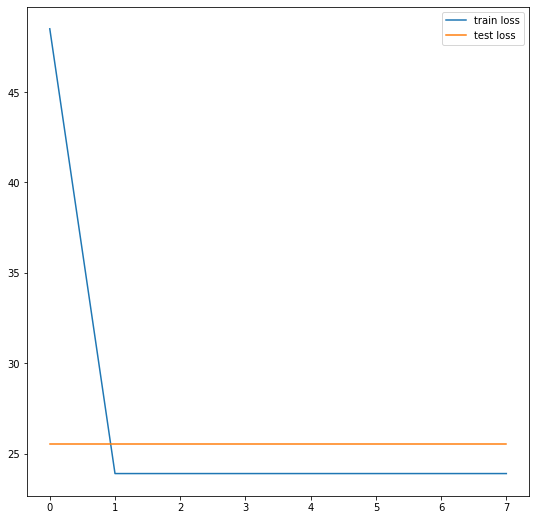

In [281]:
plt.plot(list(range(num_epochs)), train_losses, label='train loss')
plt.plot(list(range(num_epochs)), test_losses, label='test loss')
plt.legend()
plt.show()